# Non-linear filtering

We discuss and demonstrate **non-linear filtering** algorithms. They can be seen as more general alternatives to the **Kalman filter** (KF) for linear problems. In particular, the extended KF and sampling-based particle filters are studied. More detailed introductions to Bayesian filtering can be for example found in [[Särkkä, 2014](https://doi.org/10.1017/CBO9781139344203), [Candy, 2016](https://doi.org/10.1002/9780470430583)]. Among other things, mobile robot localization is an important domain of application [[Thrun et al., 2006](http://probabilistic-robotics.org)].

## Introduction

Let us consider a non-linear discrete-time model, where $\boldsymbol{x}_k$, $\boldsymbol{u}_k$ and $\boldsymbol{y}_k$ respectively symbolize the state, control and noise vectors at time step $k$. The system and its evolution are modeled by a state-transition and an observation equation. They are written as
$$
\begin{align*}
\boldsymbol{x}_k &= f(\boldsymbol{x}_{k-1}, \boldsymbol{u}_k) + \boldsymbol{w}_k, \\
\boldsymbol{y}_k &= h(\boldsymbol{x}_k) + \boldsymbol{v}_k.
\end{align*}
$$
Here, $f$ is a non-linear function of the state and control variables. Similarly, the function $h$ might be non-linear in the states. The discrete process noise $\boldsymbol{w}_k \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{Q}_k)$ and the measurement noise $\boldsymbol{v}_k \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{R}_k)$ follow Gaussian distributions.

As a reminder, filtering aims at the recursive estimation of the current state $\boldsymbol{x}_k$, given all observations $\boldsymbol{y}_{0:k}$ up to the current step. After the initialization $\pi(\boldsymbol{x}_0)$, Bayesian filtering alternates between distributions of the form $\pi(\boldsymbol{x}_k | \boldsymbol{y}_{0:k-1})$ and $\pi(\boldsymbol{x}_k | \boldsymbol{y}_{0:k})$. They constitute the prediction and update steps
$$
\begin{align*}
\pi(\boldsymbol{x}_k | \boldsymbol{y}_{0:k-1}) &=
\int \pi(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}) \,
\pi(\boldsymbol{x}_{k-1} | \boldsymbol{y}_{0:k-1}) \,
\mathrm{d} \boldsymbol{x}_{k-1}, \\
\pi(\boldsymbol{x}_k | \boldsymbol{y}_{0:k}) &=
\frac{\pi(\boldsymbol{y}_k | \boldsymbol{x}_k) \, \pi(\boldsymbol{x}_k |
\boldsymbol{y}_{0:k-1})}{\pi(\boldsymbol{y}_k | \boldsymbol{y}_{0:k-1})}.
\end{align*}
$$

The original KF solves those general filtering equations in the linear Gaussian case. In the following, we study algorithms that address the non-linear case, where one has $\pi(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}) = \mathcal{N}(\boldsymbol{x}_k | f(\boldsymbol{x}_{k-1}, \boldsymbol{u}_k), \boldsymbol{Q}_k)$ and $\pi(\boldsymbol{y}_k | \boldsymbol{x}_k) = \mathcal{N}(\boldsymbol{y}_k | h(\boldsymbol{x}_k), \boldsymbol{R}_k)$, but non-Gaussian filtering distributions.

## Extended Kalman filter

A simple variant of the KF for weakly non-linear problems is established by the **extended Kalman filter** (EKF). It modifies the original algorithm only in that it performs linearizations about the current state estimates whenever the non-linearities cannot be handled otherwise.

The state transition $\hat{\boldsymbol{x}}_{k|k-1} = f(\hat{\boldsymbol{x}}_{k-1|k-1}, \boldsymbol{u}_k)$ and the computation of the innovation $\boldsymbol{y}_k - h(\hat{\boldsymbol{x}}_{k|k-1})$ in the predict and update step, respectively, use the unaltered system functions. Other than that, one linearizes around the current estimates by reference to the partial derivatives
$$
\boldsymbol{F}_k = \left. \frac{\partial f}{\partial \boldsymbol{x}}
\right\vert_{\hat{\boldsymbol{x}}_{k-1|k-1}, \boldsymbol{u}_k}, \quad
\boldsymbol{H}_k = \left. \frac{\partial h}{\partial \boldsymbol{x}}
\right\vert_{\hat{\boldsymbol{x}}_{k|k-1}}.
$$

Following the KF algorithm, initialized with $\hat{\boldsymbol{x}}_{0|0}$, $\boldsymbol{P}_{0|0}$, one proceeds in two alternating steps. The first EKF step utilizes the exact transition equation for the state estimate, but linearly approximates the propagation of its covariance matrix. This predict step can be written as
$$
\begin{align*}
\hat{\boldsymbol{x}}_{k|k-1} &=
f(\hat{\boldsymbol{x}}_{k-1|k-1}, \boldsymbol{u}_k), \\
\boldsymbol{P}_{k|k-1} &=
\boldsymbol{F}_k \boldsymbol{P}_{k-1|k-1} \boldsymbol{F}_k^\top +
\boldsymbol{Q}_k.
\end{align*}
$$

In the second step of the EKF one starts with computing the innovation vector $\boldsymbol{y}_k - h(\hat{\boldsymbol{x}}_{k|k-1})$. Linear approximations are used for its covariance matrix $\boldsymbol{S}_k = \boldsymbol{H}_k \boldsymbol{P}_{k|k-1} \boldsymbol{H}_k^\top + \boldsymbol{R}_k$ and the near-optimal Kalman gain $\boldsymbol{K}_k = \boldsymbol{P}_{k|k-1} \boldsymbol{H}_k^\top \boldsymbol{S}_k^{-1}$. Altogether the update step is
$$
\begin{align*}
\hat{\boldsymbol{x}}_{k|k} &=
\hat{\boldsymbol{x}}_{k|k-1} +
\boldsymbol{K}_k (\boldsymbol{y}_k - h(\hat{\boldsymbol{x}}_{k|k-1})), \\
\boldsymbol{P}_{k|k} &=
\left( \boldsymbol{I} - \boldsymbol{K}_k \boldsymbol{H}_k \right) \boldsymbol{P}_{k|k-1}.
\end{align*}
$$

The EKF approximates the general filtering distributions as Gaussians. They are constructed based on the discussed linearizations. In doing so, the strict optimality properties of the KF are unfortunately lost. Moreover, the EKF tends to underestimate the uncertainties.

## Particle filters

The family of **particle filter** (PF) algorithms utilize sampling-based approximations of the Bayesian filtering equations. They work for non-linear models and avoid simplifying Gaussian assumptions or approximations. Such techniques are also referred to as **sequential Monte Carlo** (SMC). We start with an introduction to computing posterior expectations via Monte Carlo and importance sampling. Several PF schemes are subsequently introduced.

### Importance sampling

Let us consider a general posterior $\pi(\boldsymbol{x} | \boldsymbol{y}) = Z^{-1} \pi(\boldsymbol{y} | \boldsymbol{x}) \pi(\boldsymbol{x})$ with $Z = \int \pi(\boldsymbol{y} | \boldsymbol{x}) \pi(\boldsymbol{x}) \, \mathrm{d} \boldsymbol{x}$. If one could draw $N$ random samples $\boldsymbol{x}^{(i)} \sim \pi(\boldsymbol{x}^{(i)} | \boldsymbol{y})$ for $i=1,\ldots,N$ independently from this distribution, expected values would be approximated via **Monte Carlo** (MC) simulation
$$
\mathbb{E}[g(\boldsymbol{x}) | \boldsymbol{y}] =
\int g(\boldsymbol{x}) \, \pi(\boldsymbol{x} | \boldsymbol{y}) \, \mathrm{d} \boldsymbol{x} \approx
\frac{1}{N} \sum_{i=1}^N g(\boldsymbol{x}^{(i)}).
$$

Normally, however, the target cannot be sampled easily. Instead, if independent samples could be generated from an auxiliary distribution $\boldsymbol{x}^{(i)} \sim q(\boldsymbol{x}^{(i)} | \boldsymbol{y})$ with greater or equal support, then the posterior expectations could be approximated by **importance sampling** (IS) as follows
$$
\mathbb{E}[g(\boldsymbol{x}) | \boldsymbol{y}] =
\int g(\boldsymbol{x}) \frac{\pi(\boldsymbol{x} | \boldsymbol{y})}{q(\boldsymbol{x} | \boldsymbol{y})}
q(\boldsymbol{x} | \boldsymbol{y}) \, \mathrm{d} \boldsymbol{x} \approx
\sum_{i=1}^N \tilde{w}^{(i)} g(\boldsymbol{x}^{(i)}), \quad
\tilde{w}^{(i)} = \frac{1}{N}
\frac{\pi(\boldsymbol{x}^{(i)} | \boldsymbol{y})}{q(\boldsymbol{x}^{(i)} | \boldsymbol{y})}.
$$

This is still of little practical use unless the posterior density $\pi(\boldsymbol{x} | \boldsymbol{y})$ can be evaluated analytically. As a remedy, one can apply the IS re-weighting simultaneously to the numerator and denominator in order to obtain
$$
\mathbb{E}[g(\boldsymbol{x}) | \boldsymbol{y}] =
\frac{\int g(\boldsymbol{x}) \, \pi(\boldsymbol{y} | \boldsymbol{x}) \, \pi(\boldsymbol{x}) \, \mathrm{d} \boldsymbol{x}}{\int \pi(\boldsymbol{y} | \boldsymbol{x}) \, \pi(\boldsymbol{x}) \, \mathrm{d} \boldsymbol{x}} =
\frac{\int g(\boldsymbol{x}) \frac{\pi(\boldsymbol{y} | \boldsymbol{x}) \pi(\boldsymbol{x})}{q(\boldsymbol{x} | \boldsymbol{y})} q(\boldsymbol{x} | \boldsymbol{y}) \, \mathrm{d} \boldsymbol{x}}{\int \frac{\pi(\boldsymbol{y} | \boldsymbol{x}) \pi(\boldsymbol{x})}{q(\boldsymbol{x} | \boldsymbol{y})} q(\boldsymbol{x} | \boldsymbol{y}) \, \mathrm{d} \boldsymbol{x}}.
$$
Posterior expected values are then approximated with the generated samples $\boldsymbol{x}^{(i)}$ for $i=1,\ldots,N$ and the corresponding evaluations of the likelihood $\pi(\boldsymbol{y} | \boldsymbol{x}^{(i)})$, the prior density $\pi(\boldsymbol{x}^{(i)})$ and the auxiliary density $q(\boldsymbol{x}^{(i)} | \boldsymbol{y})$. This is written as
$$
\mathbb{E}[g(\boldsymbol{x}) | \boldsymbol{y}] \approx
\sum_{i=1}^N w^{(i)} g(\boldsymbol{x}^{(i)}), \quad
w^{(i)} = \frac{\pi(\boldsymbol{y} | \boldsymbol{x}^{(i)}) \, \pi(\boldsymbol{x}^{(i)})}{q(\boldsymbol{x}^{(i)} | \boldsymbol{y})}
\left( \sum_{j=1}^N \frac{\pi(\boldsymbol{y} | \boldsymbol{x}^{(j)}) \, \pi(\boldsymbol{x}^{(j)})}{q(\boldsymbol{x}^{(j)} | \boldsymbol{y})} \right)^{-1}.
$$
That the importance weights $w^{(i)}$ are normalized versions of $\pi(\boldsymbol{y} | \boldsymbol{x}^{(i)}) \pi(\boldsymbol{x}^{(i)}) / q(\boldsymbol{x}^{(i)} | \boldsymbol{y})$ facilitates their practical computation. An IS-based representation of the posterior density can be formally written as $\pi(\boldsymbol{x} | \boldsymbol{y}) \approx \sum_{i=1}^N w^{(i)} \delta(\boldsymbol{x} - \boldsymbol{x}^{(i)})$.

### Sequential importance sampling

Similar to described above, one can proceed for a posterior of the form $\pi(\boldsymbol{x}_{0:k} | \boldsymbol{y}_{0:k}) = Z_{0:k}^{-1} \pi(\boldsymbol{x}_0) \prod_{i=0}^k \pi(\boldsymbol{y}_i | \boldsymbol{x}_i) \prod_{i=1}^k \pi(\boldsymbol{x}_i | \boldsymbol{x}_{i-1})$. As a consequence of the Markovian model, the posterior $\pi(\boldsymbol{x}_{0:k} | \boldsymbol{y}_{0:k})$ at time step $k$ is recursively related to its predecessor $\pi(\boldsymbol{x}_{0:k-1} | \boldsymbol{y}_{0:k-1})$ at $k-1$ through
$$
\pi(\boldsymbol{x}_{0:k} | \boldsymbol{y}_{0:k}) =
\frac{Z_{0:k-1}}{Z_{0:k}}
\pi(\boldsymbol{y}_k | \boldsymbol{x}_k) \,
\pi(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}) \,
\pi(\boldsymbol{x}_{0:k-1} | \boldsymbol{y}_{0:k-1}).
$$
A recursive IS scheme can then be devised based on draws from an auxiliary distribution $\boldsymbol{x}_{0:k}^{(i)} \sim q(\boldsymbol{x}_{0:k}^{(i)} | \boldsymbol{y}_{0:k})$ for $i=1,\ldots,N$. In doing so, if the latter density is built in sequential fashion $q(\boldsymbol{x}_{0:k} | \boldsymbol{y}_{0:k}) = q(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}, \boldsymbol{y}_{0:k}) q(\boldsymbol{x}_{0:k-1} | \boldsymbol{y}_{0:k-1})$, one obtains a recursion for the weights
$$
w_k^{(i)} \propto \frac{\pi(\boldsymbol{y}_k | \boldsymbol{x}_k^{(i)}) \, \pi(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)}) \, \pi(\boldsymbol{x}_{0:k-1}^{(i)} | \boldsymbol{y}_{0:k-1})}{q(\boldsymbol{x}_{0:k}^{(i)} | \boldsymbol{y}_{0:k})} =
\frac{\pi(\boldsymbol{y}_k | \boldsymbol{x}_k^{(i)}) \, \pi(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)})}{q(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)}, \boldsymbol{y}_{0:k})}
\underbrace{\frac{\pi(\boldsymbol{x}_{0:k-1}^{(i)} | \boldsymbol{y}_{0:k-1})}{q(\boldsymbol{x}_{0:k-1}^{(i)} | \boldsymbol{y}_{0:k-1})}}_{\propto w_{k-1}^{(i)}}.
$$
Beyond that, because of the recursive structure of the auxiliary distribution, samples $\boldsymbol{x}_k^{(i)}$ can be randomly generated by $\boldsymbol{x}_k^{(i)} \sim q(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)}, \boldsymbol{y}_{0:k})$ from samples $\boldsymbol{x}_{k-1}^{(i)}$ at the previous step.

Based on this sampling strategy, expectations under the full posterior are simulated as $\mathbb{E}[g(\boldsymbol{x}_{0:k}) | \boldsymbol{y}_{0:k}] \approx \sum_{i=1}^N w_k^{(i)} g(\boldsymbol{x}_{0:k}^{(i)})$. That means that the posterior density is formally approximated as $\pi(\boldsymbol{x}_{0:k} | \boldsymbol{y}_{0:k}) \approx \sum_{i=1}^N w_k^{(i)} \delta(\boldsymbol{x}_{0:k} - \boldsymbol{x}_{0:k}^{(i)})$. The filtering distribution $\pi(\boldsymbol{x}_k | \boldsymbol{y}_{0:k}) = \int \pi(\boldsymbol{x}_{0:k} | \boldsymbol{y}_{0:k}) \, \mathrm{d} \boldsymbol{x}_{0:k-1}$ is a marginal of the full posterior. It can be approximated by simply disregarding the past $\boldsymbol{x}_{0:k-1}^{(i)}$ and focussing on the current $\boldsymbol{x}_k^{(i)}$. One then has
$$
\mathbb{E}[g(\boldsymbol{x}_k) | \boldsymbol{y}_{0:k}] \approx
\sum_{i=1}^N w_k^{(i)} g(\boldsymbol{x}_k^{(i)})
$$
for the expectations and $\pi(\boldsymbol{x}_k | \boldsymbol{y}_{0:k}) \approx \sum_{i=1}^N w_k^{(i)} \delta(\boldsymbol{x}_k - \boldsymbol{x}_k^{(i)})$ for the density. In this context, $(\boldsymbol{x}_k^{(i)}, w_k^{(i)})$ for $i=1,\ldots,N$ are called **particles**. They are just importance-weighted samples from the auxiliary distribution.

The **sequential importance sampling** (SIS) scheme is now summarized. One starts by drawing $N$ samples from the prior distribution $\boldsymbol{x}_0^{(i)} \sim \pi(\boldsymbol{x}_0^{(i)})$ and by setting the initial weights to $w_0^{(i)} = 1/N$ for $i=1,\ldots,N$. One iterates as follows after this initialization. In each step $k$ one generates new samples $\boldsymbol{x}_k^{(i)} \sim q(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)}, \boldsymbol{y}_{0:k})$ from the old ones $\boldsymbol{x}_{k-1}^{(i)}$. Similarly, the corresponding weights $w_k^{(i)} \propto w_{k-1}^{(i)} \pi(\boldsymbol{y}_k | \boldsymbol{x}_k^{(i)}) \pi(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)}) / q(\boldsymbol{x}_k^{(i)} | \boldsymbol{x}_{k-1}^{(i)}, \boldsymbol{y}_{0:k})$ are first computed from their old values $w_{k-1}^{(i)}$. Thereafter, they are normalized such that they sum to one.

A practial difficulty is the selection of an appropriate importance density. Optimally, $q(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}, \boldsymbol{y}_{0:k}) = \pi(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}, \boldsymbol{y}_k) \propto \pi(\boldsymbol{y}_k | \boldsymbol{x}_k) \pi(\boldsymbol{x}_k | \boldsymbol{x}_{k-1})$, but this is usually not feasible. If it would be possible, one could in fact sample the posterior sequentially and directly, which in turn would render the whole SIS redundant. It is remarked that for such a hypothetical choice, the importance weights $w_k^{(i)} = w_{k-1}^{(i)}$ would remain constant.

### Sequential importance resampling

SIS particle filtering via suffers from a well-known degeneracy problem. It refers to the situation that after a couple of algorithmic iterations, all but very few particles have negligible weights. This limits how well the posterior distribution can be represented through the particles.

The **sequential importance resampling** (SIR) scheme introduces an additional resampling step in order to overcome this problem. At the end of an iteration, the particles are bootstrapped, that means randomly sampled with replacement. Their current weights are used as the discrete probabilities $P(\boldsymbol{x}_{k,\mathrm{new}}^{(j)} = \boldsymbol{x}_k^{(i)}) = w_k^{(i)}$ for $j=1,\ldots,N$ of a categorical distribution. Subsequently, the weights are uniformly reset to $w_{k,\mathrm{new}}^{(j)} = 1/N$. Such a resampling can be done at regular intervals or when the effective particle number drops below a certain fraction of the total number.

A simple SIR variant is the **bootstrap filter**. It owes its name to the fact that it resamples at the end of each iteration. In addition, it merely employs the state transition prior as an importance density $q(\boldsymbol{x}_k | \boldsymbol{x}_{k-1}, \boldsymbol{y}_{0:k}) = \pi(\boldsymbol{x}_k | \boldsymbol{x}_{k-1})$. The weight update reduces to $w_k^{(i)} \propto w_{k-1}^{(i)} \pi(\boldsymbol{y}_k | \boldsymbol{x}_k^{(i)})$ for such a data-independent construction. This is appealing for its simplicity and conceptionally resembles the two-step predict/update approach of the KF.

## Demonstration

We now consider a noisy gravity pendulum which is frequently discussed in [[Särkkä, 2014](https://doi.org/10.1017/CBO9781139344203), [Särkkä and Solin, 2019](https://doi.org/10.1017/9781108186735)]. This is one of the simplest but useful non-linear examples. In terms of the non-linearities, it is reminiscent of widely used localization task models, for example in robotics. After the model specification, an experiment with simulated data is conducted, where the stochastic system is state-estimated via EKF and PF algorithms.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

The motion of a **simple pendulum** can be described by the ordinary differential equation $\ddot{\theta} = -g/l \sin(\theta)$, where $\theta$ is the angular displacement. The gravitational acceleration is denoted as $g$ and the length is $l$. Notice that the small-angle approximation $\sin(\theta) \approx \theta$ would yield a harmonic oscillator. If one additionally assumes that randomly acting forces cause acceleration changes, one obtains the model of a **stochastic pendulum**
$$
\frac{\mathrm{d}^2 \theta}{\mathrm{d} t^2} = -\frac{g}{l} \sin(\theta) + w(t).
$$
Here, $w(t)$ is a continuous-time Gaussian white noise process with $\mathbb{E}[w(t)] = 0$ and $\mathbb{E}[w(t) w(\tau)] = \sigma_w^2 \delta(t-\tau)$. One can define the state variables $\boldsymbol{x} = (x_1, x_2)^\top = (\theta, \dot{\theta})^\top$ in order to write the model in the non-linear continuous-time state-space form
$$
\begin{pmatrix} \dot{x}_1 \\ \dot{x}_2 \end{pmatrix} =
\begin{pmatrix} x_2 \\ -\frac{g}{l} \sin(x_1) \end{pmatrix} +
\begin{pmatrix} 0 \\ 1 \end{pmatrix} w(t).
$$

It is noted that the non-linearity has emerged due to simple trigonometry. As a matter of fact, this analogously happens for many other geometry-related models involving angles. One can derive a discretized and approximate but non-linear state-space model
$$
\underbrace{\begin{pmatrix} x_{1,k} \\ x_{2,k} \end{pmatrix}}_{\boldsymbol{x}_k} =
\underbrace{\begin{pmatrix}
x_{1,k-1} + x_{2,k-1} \Delta t \\
x_{2,k-1} -\frac{g}{l} \sin(x_{1,k-1}) \Delta t
\end{pmatrix}}_{f(\boldsymbol{x}_{k-1})} +
\underbrace{\begin{pmatrix} w_{1,k} \\ w_{2,k} \end{pmatrix}}_{\boldsymbol{w}_k}, \quad
\boldsymbol{Q} = \sigma_w^2
\begin{pmatrix}
\frac{1}{3} (\Delta t)^3 & \frac{1}{2} (\Delta t)^2 \\
\frac{1}{2} (\Delta t)^2 & \Delta t
\end{pmatrix}.
$$
The discrete-time noise random variable $\boldsymbol{w}_k = (w_{1,k}, w_{2,k})^\top \sim \mathcal{N}(\boldsymbol{0},\boldsymbol{Q})$ follows a Gaussian distribution with covariance $\boldsymbol{Q}$. This result ensues from a small-angle simplification of the continuous equations and a first-order time-discretization of the solution.

A common scenario is that angular displacements can be measured subject to normally distributed noise. The observation model completes the problem setup. For the sake of completeness, it is written as
$$
y_k = x_{1,k} + v_k, \quad v_k \sim \mathcal{N}(0, \sigma_v^2).
$$

It is recalled that the EKF demands linearizations of both the transition and observation model at the current state estimates. Because our measurement model is already linear, we only have to linearize the discrete-time transition model. This is accomplished by means of the Jacobian matrix
$$
\boldsymbol{F}_k = \boldsymbol{J}_f(\boldsymbol{x}_{k-1}) =
\left. \frac{\partial f}{\partial \boldsymbol{x}}
\right\vert_{\boldsymbol{x}_{k-1}} =
\begin{pmatrix} 1 & \Delta t \\ -\frac{g}{l} \cos(x_{1,k-1}) \Delta t & 1 \end{pmatrix}.
$$

Let us shortly investigate how this relates to the predict step. Provided that $f(\boldsymbol{x})$ is a function of some random variable $\boldsymbol{x} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$, the first-order Taylor expansion about the mean is $f(\boldsymbol{x}) = f(\boldsymbol{\mu} + \Delta \boldsymbol{x}) \approx f(\boldsymbol{\mu}) + \boldsymbol{J}_f(\boldsymbol{\mu}) \Delta \boldsymbol{x}$. Consequentially, the linear approximations of the transformed mean and covariance are $\mathbb{E}[f(\boldsymbol{x})] \approx f(\boldsymbol{\mu})$ and $\mathrm{Cov}[f(\boldsymbol{x})] \approx \boldsymbol{J}_f(\boldsymbol{\mu}) \boldsymbol{\Sigma} \boldsymbol{J}_f(\boldsymbol{\mu})^\top$, respectively, which exactly corresponds to the EKF predict step.

### Simulation

We start with a simulator of the stochastic pendulum as discussed above. It randomly generates sample paths based on the discrete model. A symplectic leapfrog integrator, which enhances stability due to conserving an approximate energy, is employed for the time stepping. The simplest such method performs only one time step: a half step for the positions, followed by a full step for the velocities, completed by a half position step.

In [3]:
class StochasticPendulum():
    '''Simulator of the stochastic pendulum.'''

    def __init__(self, g, l, dt, sigma_w, sigma_v, x0=None):
        self.g = g
        self.l = l
        self.dt = dt
        self.process_noise = norm(scale=sigma_w * np.sqrt(dt))
        self.measure_noise = norm(scale=sigma_v)
        if x0 is None:
            self.x = np.zeros((2,1))
        else:
            self.x = np.array(x0).reshape((2,1)).astype('float')

    def evolve(self):
        self.x[0] += 0.5 * self.x[1] * self.dt
        self.x[1] += -self.g / self.l * np.sin(self.x[0]) * self.dt
        self.x[1] += self.process_noise.rvs()
        self.x[0] += 0.5 * self.x[1] * self.dt

    def observe(self):
        return self.x[0] + self.measure_noise.rvs()

    def get_state(self):
        return self.x.squeeze()

In [4]:
g = 10 # gravitational acceleration
l = 0.1 # pendulum length
dt = 0.01 # time step
sigma_w = 1 # process noise intensity
sigma_v = 0.05 # measurement noise level
x0 = (0.2, 0) # initial state

In [5]:
real_system = StochasticPendulum(g, l, dt, sigma_w, sigma_v, x0)

In [6]:
no_steps = 300
x_true = np.zeros((no_steps+1,2))
y_meas = np.zeros(no_steps)
x_true[0] = real_system.get_state()
for k in range(no_steps):
    real_system.evolve()
    x_true[k+1] = real_system.get_state()
    y_meas[k] = real_system.observe()

<IPython.core.display.Javascript object>


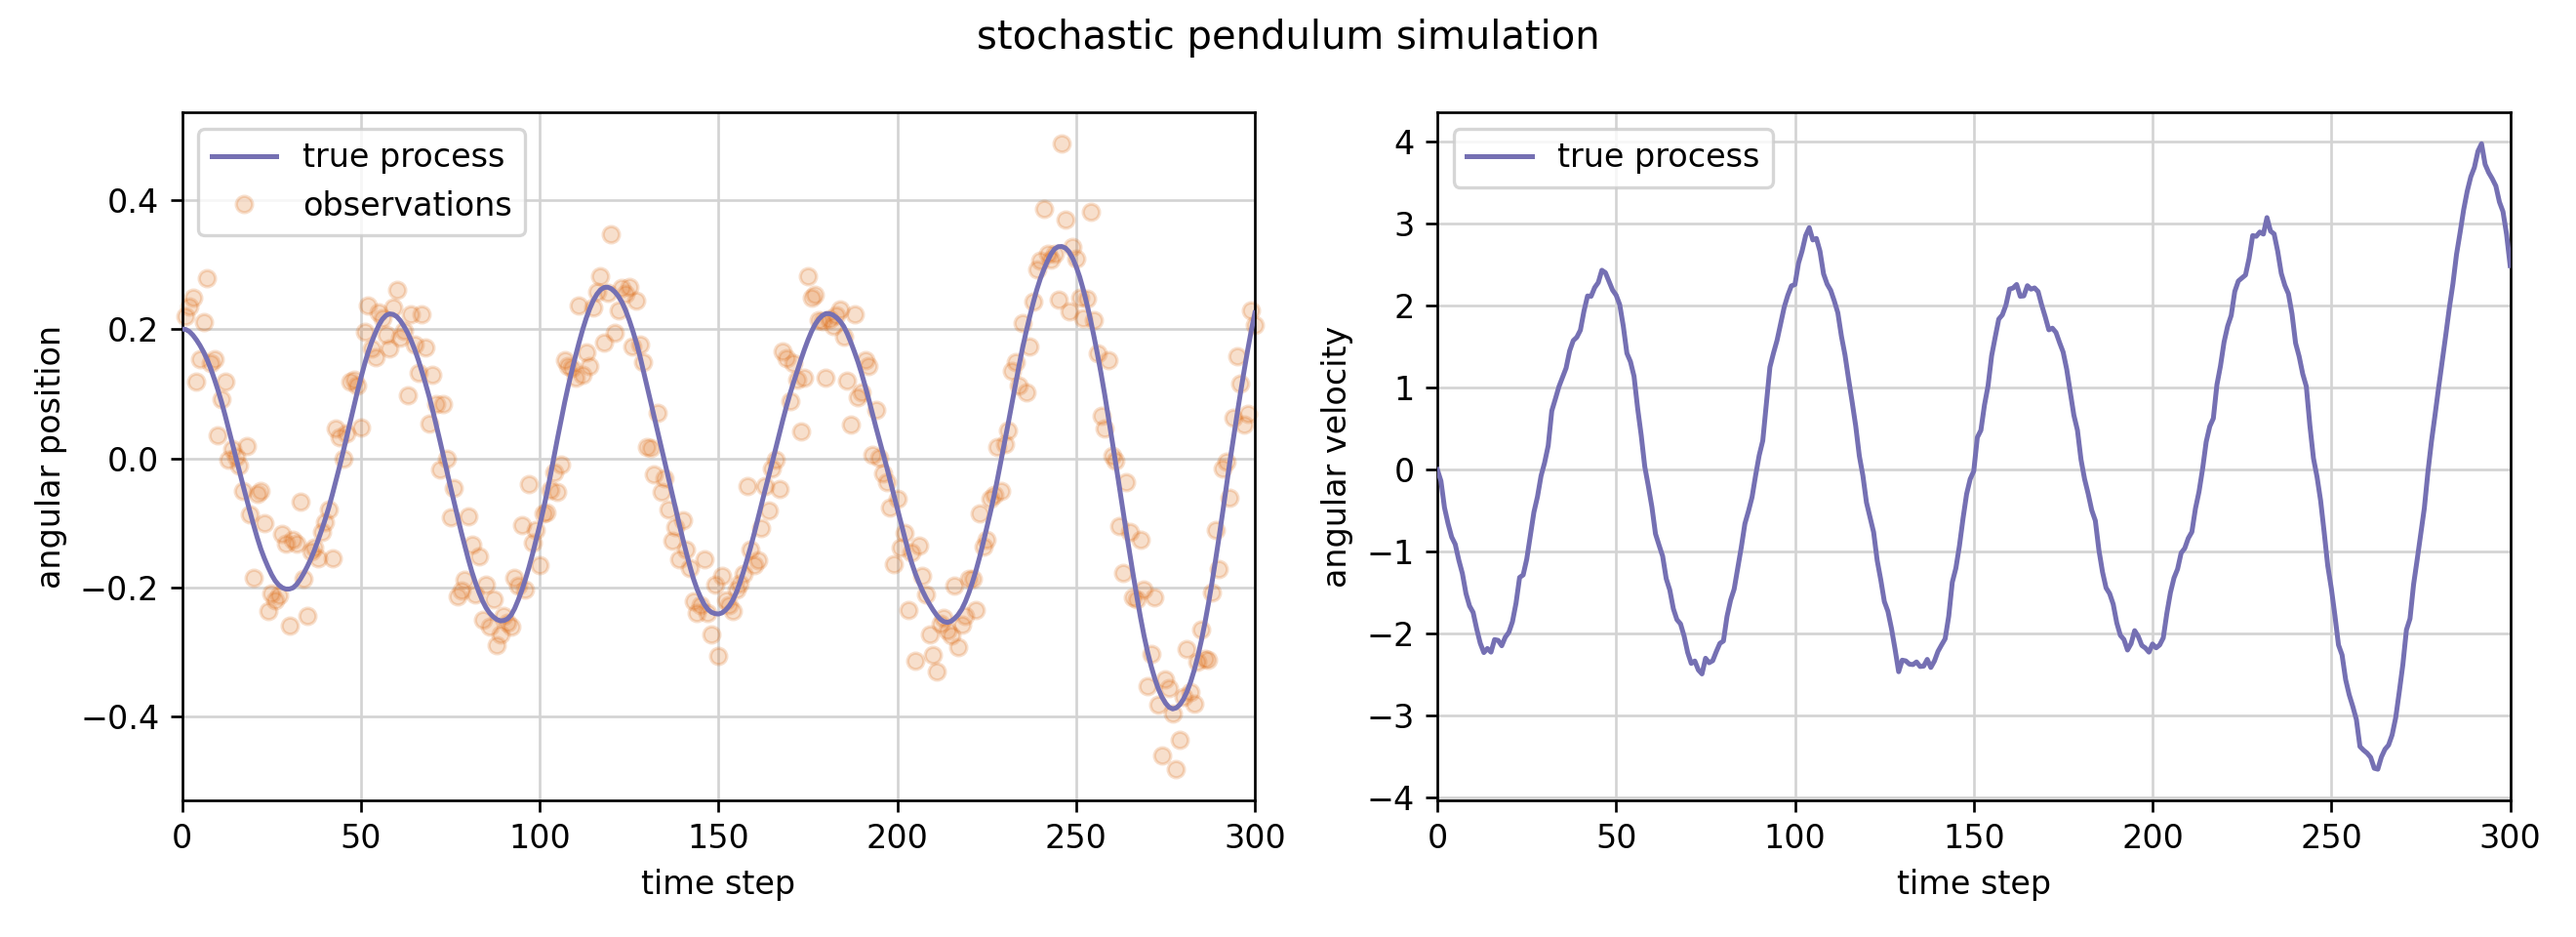

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
axes[0].plot(np.arange(no_steps+1), x_true[:,0], color=plt.cm.Dark2(2), zorder=3, label='true process')
axes[0].plot(np.arange(1,no_steps+1), y_meas, linestyle='', marker='o', markersize=5,
             color=plt.cm.Dark2(1), alpha=0.2, clip_on=False, zorder=2, label='observations')
axes[0].set(xlabel='time step', ylabel='angular position', xlim=(0,no_steps))
axes[1].plot(np.arange(no_steps+1), x_true[:,1], color=plt.cm.Dark2(2), zorder=3, label='true process')
axes[1].set(xlabel='time step', ylabel='angular velocity', xlim=(0,no_steps))
for ax in axes.ravel().tolist():
    ax.legend()
    ax.grid(b=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
fig.suptitle('stochastic pendulum simulation')
fig.tight_layout()
fig.show()

### Extended Kalman filter

The EKF algorithm is now applied in order to state-estimate the stochastically driven pendulum in real-time. In the present case, the observation model is already linear and therefore does not require special attention. Only the transition model has to be linearized about the current state estimates. Eventually, we can compare the estimated states and their uncertainties against the actually realized values of the simulated process.

In [8]:
class ExtendedKalmanFilter():
    '''Naive implementation of the extended Kalman filter.'''

    def __init__(self, g, l, dt,
                 sigma_w, sigma_v,
                 x0=None, P0=None):
        self.g = g
        self.l = l
        self.dt = dt
        self.Q = np.array([[(dt**3)/3, (dt**2)/2],
                           [(dt**2)/2, dt]]) * sigma_w**2
        self.H = np.array([[1., 0.]])
        self.R = sigma_v**2
        if x0 is None:
            self.x = np.zeros((2,1))
        else:
            self.x = np.array(x0).reshape((2,1)).astype('float')
        if P0 is None:
            self.P = np.eye(2)
        else:
            self.P = np.array(P0).reshape((2,2)).astype('float')

    @property
    def F(self):
        return np.array([[1, self.dt],
                         [-self.g/self.l*np.cos(self.x[0].item())*self.dt, 1]])

    def predict(self):
        self.x[0] += 0.5 * self.x[1] * self.dt
        self.x[1] += -self.g / self.l * np.sin(self.x[0]) * self.dt
        self.x[0] += 0.5 * self.x[1] * self.dt
        self.P = self.F.dot(self.P).dot(self.F.T) + self.Q

    def update(self, y):
        y = np.asarray(y).reshape((-1,1))
        S = self.H.dot(self.P).dot(self.H.T) + self.R
        K = self.P.dot(self.H.T).dot(np.linalg.inv(S))
        self.x = self.x + K.dot(y - self.H.dot(self.x))
        self.P = (np.eye(self.P.shape[0]) - K.dot(self.H)).dot(self.P)

    def get_state(self):
        return self.x.squeeze(), self.P

In [9]:
real_system = StochasticPendulum(g, l, dt, sigma_w, sigma_v, x0)
extended_kf = ExtendedKalmanFilter(g, l, dt, sigma_w, sigma_v, x0)

In [10]:
no_steps = 300
x_true = np.zeros((no_steps+1,2))
y_meas = np.zeros(no_steps)
x_hat = np.zeros((no_steps,2))
P_hat = np.zeros((no_steps,2,2))
x_true[0] = real_system.get_state()
for k in range(no_steps):
    real_system.evolve()
    x_true[k+1] = real_system.get_state()
    y_meas[k] = real_system.observe()
    extended_kf.predict()
    extended_kf.update(y_meas[k])
    x_hat[k], P_hat[k] = extended_kf.get_state()

<IPython.core.display.Javascript object>


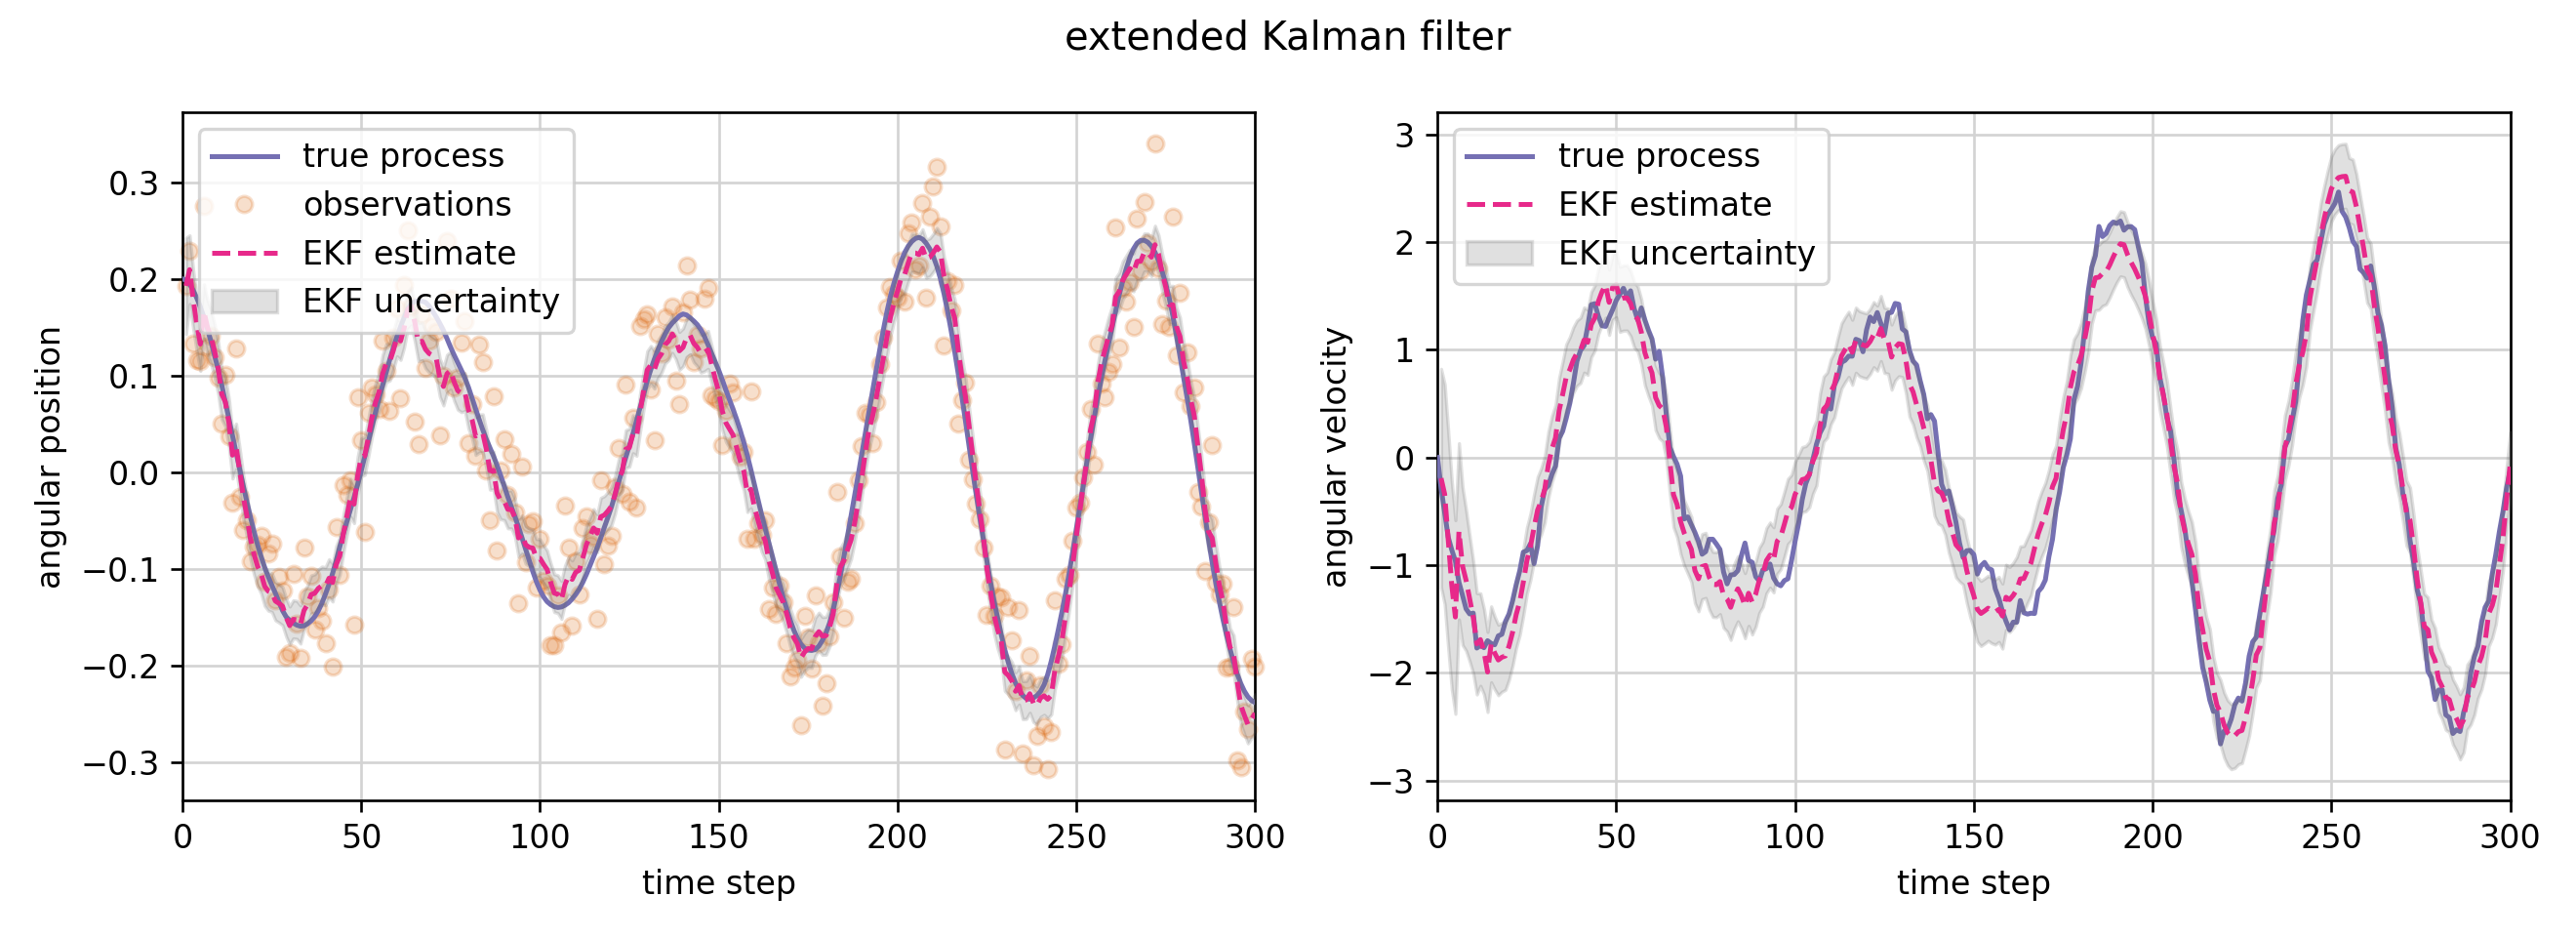

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
axes[0].plot(np.arange(no_steps+1), x_true[:,0], color=plt.cm.Dark2(2), zorder=3, label='true process')
axes[0].plot(np.arange(1,no_steps+1), y_meas, linestyle='', marker='o', markersize=5,
             color=plt.cm.Dark2(1), alpha=0.2, clip_on=False, zorder=2, label='observations')
axes[0].plot(np.arange(1,no_steps+1), x_hat[:,0], linestyle='--',
             color=plt.cm.Dark2(3), zorder=5, label='EKF estimate')
axes[0].fill_between(np.arange(1,no_steps+1), x_hat[:,0]-np.sqrt(P_hat[:,0,0]), x_hat[:,0]+np.sqrt(P_hat[:,0,0]),
                     color=plt.cm.Dark2(7), alpha=0.2, zorder=4, label='EKF uncertainty')
axes[0].set(xlabel='time step', ylabel='angular position', xlim=(0,no_steps))
axes[1].plot(np.arange(no_steps+1), x_true[:,1], color=plt.cm.Dark2(2), zorder=3, label='true process')
axes[1].plot(np.arange(1,no_steps+1), x_hat[:,1], linestyle='--',
             color=plt.cm.Dark2(3), zorder=5, label='EKF estimate')
axes[1].fill_between(np.arange(1,no_steps+1), x_hat[:,1]-np.sqrt(P_hat[:,1,1]), x_hat[:,1]+np.sqrt(P_hat[:,1,1]),
                     color=plt.cm.Dark2(7), alpha=0.2, zorder=4, label='EKF uncertainty')
axes[1].set(xlabel='time step', ylabel='angular velocity', xlim=(0,no_steps))
for ax in axes.ravel().tolist():
    ax.legend()
    ax.grid(b=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
fig.suptitle('extended Kalman filter')
fig.tight_layout()
fig.show()

### Particle filter

We adapt a PF for the state estimation of the noisy pendulum under stochastic excitations. Specifically, a bootstrap PF is used, since it is one of the most intuitive and easy-to-implement SIR schemes. The auxiliary importance density is basically given by the prior model of the state evolution; resampling is done after every step. Again, the state estimates and their uncertainties are compared to the actual values of the simulated process.

In [12]:
class BootstrapParticleFilter():
    '''Particle filter algorithm with a bootstrap scheme.'''

    def __init__(self, g, l, dt,
                 sigma_w, sigma_v,
                 x0=None, P0=None,
                 no_particles=100):
        self.g = g
        self.l = l
        self.dt = dt
        self.Q = np.array([[(dt**3)/3, (dt**2)/2],
                           [(dt**2)/2, dt]]) * sigma_w**2
        self.sigma_v = sigma_v
        if x0 is None:
            x0 = np.zeros((2,))
        else:
            x0 = np.array(x0).reshape((2,)).astype('float')
        if P0 is None:
            P0 = np.eye(2)
        else:
            P0 = np.array(P0).reshape((2,2)).astype('float')
        self.samples = multivariate_normal(mean=x0, cov=P0).rvs(size=no_particles)
        self.weights = np.ones((no_particles,)) / no_particles

    @property
    def no_particles(self):
        return len(self.samples)

    def _sample(self):
        self.samples[:,0] += 0.5 * self.samples[:,1] * self.dt
        self.samples[:,1] += -self.g / self.l * np.sin(self.samples[:,0]) * self.dt
        self.samples[:,0] += 0.5 * self.samples[:,1] * self.dt
        self.samples += multivariate_normal(cov=self.Q).rvs(size=self.no_particles)

    def _reweight(self, y):
        self.weights *= norm(loc=self.samples[:,0], scale=self.sigma_v).pdf(y)
        self.weights /= self.weights.sum()

    def update(self, y):
        self._sample()
        self._reweight(y)

    def resample(self, no_particles=None):
        if no_particles is None:
            no_particles = self.no_particles
        random_ids = np.random.choice(self.no_particles,
                                      size=no_particles,
                                      replace=True,
                                      p=self.weights)
        self.samples = self.samples[random_ids]
        self.weights = np.ones((no_particles,)) / no_particles

    def estimate(self):
        mean = np.average(self.samples, axis=0, weights=self.weights)
        cov = np.diag(np.average((self.samples-mean)**2, axis=0, weights=self.weights))
        cov[1,0] = cov[0,1] = np.average((self.samples[:,0]-mean[0])*(self.samples[:,1]-mean[1]),
                                         axis=0, weights=self.weights)
        return mean, cov

In [13]:
real_system = StochasticPendulum(g, l, dt, sigma_w, sigma_v, x0)
bootstrap_pf = BootstrapParticleFilter(g, l, dt, sigma_w, sigma_v, x0, no_particles=1000)

In [14]:
no_steps = 300
x_true = np.zeros((no_steps+1,2))
y_meas = np.zeros(no_steps)
x_hat = np.zeros((no_steps,2))
P_hat = np.zeros((no_steps,2,2))
x_true[0] = real_system.get_state()
for k in range(no_steps):
    real_system.evolve()
    x_true[k+1] = real_system.get_state()
    y_meas[k] = real_system.observe()
    bootstrap_pf.update(y_meas[k])
    x_hat[k], P_hat[k] = bootstrap_pf.estimate()
    bootstrap_pf.resample()

<IPython.core.display.Javascript object>


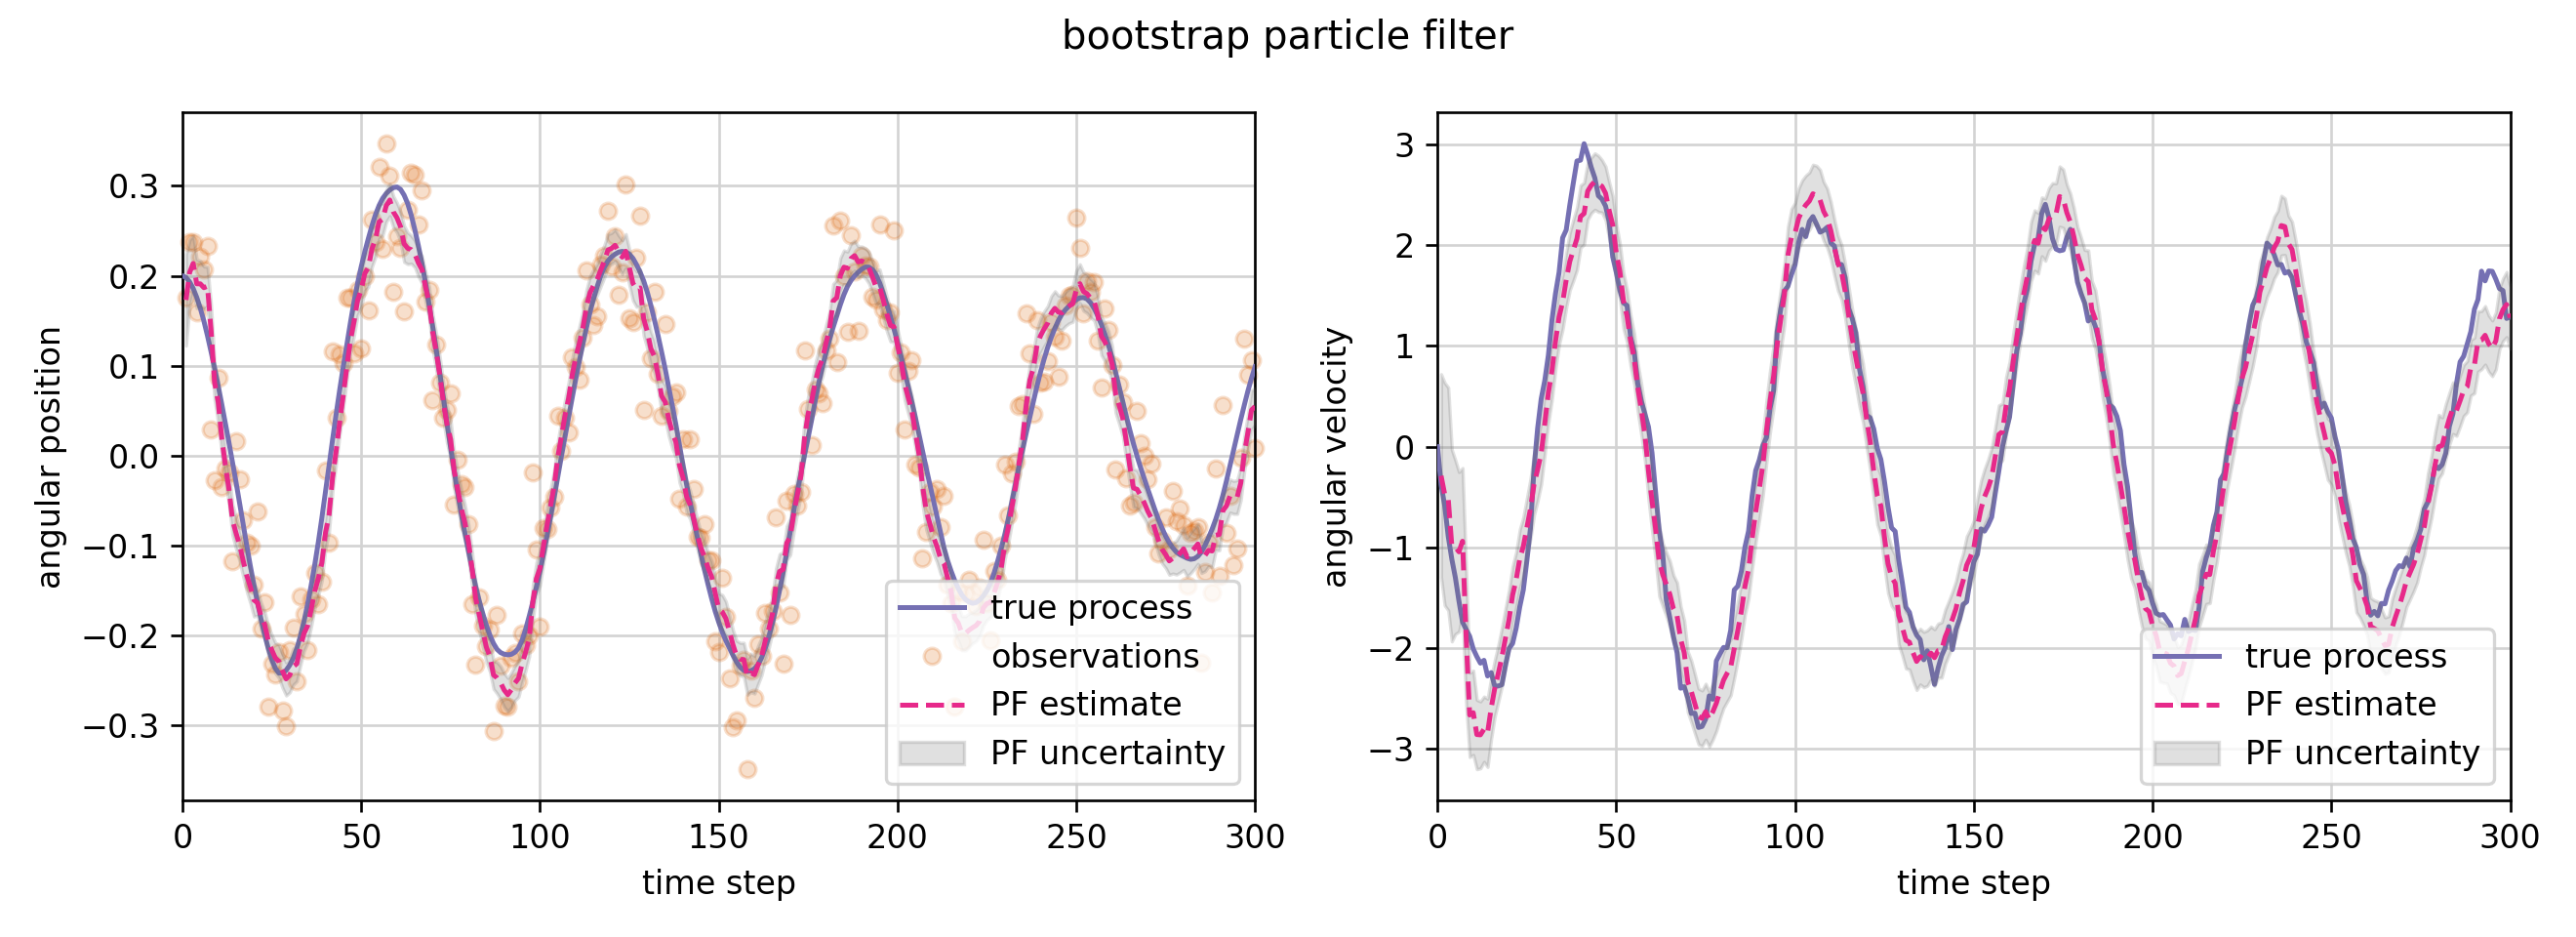

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
axes[0].plot(np.arange(no_steps+1), x_true[:,0], color=plt.cm.Dark2(2), zorder=3, label='true process')
axes[0].plot(np.arange(1,no_steps+1), y_meas, linestyle='', marker='o', markersize=5,
             color=plt.cm.Dark2(1), alpha=0.2, clip_on=False, zorder=2, label='observations')
axes[0].plot(np.arange(1,no_steps+1), x_hat[:,0], linestyle='--',
             color=plt.cm.Dark2(3), zorder=5, label='PF estimate')
axes[0].fill_between(np.arange(1,no_steps+1), x_hat[:,0]-np.sqrt(P_hat[:,0,0]), x_hat[:,0]+np.sqrt(P_hat[:,0,0]),
                     color=plt.cm.Dark2(7), alpha=0.2, zorder=4, label='PF uncertainty')
axes[0].set(xlabel='time step', ylabel='angular position', xlim=(0,no_steps))
axes[1].plot(np.arange(no_steps+1), x_true[:,1], color=plt.cm.Dark2(2), zorder=3, label='true process')
axes[1].plot(np.arange(1,no_steps+1), x_hat[:,1], linestyle='--',
             color=plt.cm.Dark2(3), zorder=5, label='PF estimate')
axes[1].fill_between(np.arange(1,no_steps+1), x_hat[:,1]-np.sqrt(P_hat[:,1,1]), x_hat[:,1]+np.sqrt(P_hat[:,1,1]),
                     color=plt.cm.Dark2(7), alpha=0.2, zorder=4, label='PF uncertainty')
axes[1].set(xlabel='time step', ylabel='angular velocity', xlim=(0,no_steps))
for ax in axes.ravel().tolist():
    ax.legend()
    ax.grid(b=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)
fig.suptitle('bootstrap particle filter')
fig.tight_layout()
fig.show()